# Notebook for evaluating and visualizing results of grid searches

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import os
import sys
import numpy as np 
import random
import math
import json
from copy import copy
from glob import glob
from statistics import mean, stdev

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

In [2]:
def load_gridsearch(checkpoint_dir):
    folders = sorted(glob(os.path.join(checkpoint_dir, "*")))
    folders = [f for f in folders if os.path.isdir(f)]
    
    results = {}
    exp_args = {}
    for f in folders:
        f_name = f.split("/")[-1]
        results[f_name] = []
        metric_files = sorted(glob(os.path.join(f, 'metrics_full_log_*.json')))
        for m_file in metric_files:
            with open(m_file, "r") as file_pointer:
                results[f_name].append(json.load(file_pointer))
                
        args_file = os.path.join(f, "args.json")
        assert os.path.isfile(args_file), "Cannot find file %s" % args_file
        with open(args_file, "r") as file_pointer:
            exp_args[f_name] = json.load(file_pointer)
    return results, exp_args

In [3]:
# results, exp_args = load_gridsearch("checkpoints/array_job_7503951/")
# results, exp_args = load_gridsearch("checkpoints/array_job_7509255/")
# results, exp_args = load_gridsearch("checkpoints/array_job_toy_7522731/")
# results, exp_args = load_gridsearch("checkpoints/array_job_toy_7523023/")
results, exp_args = load_gridsearch("checkpoints/array_job_toy_7523230/")

In [4]:
results.keys()

dict_keys(['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4', 'experiment_5', 'experiment_6'])

In [5]:
results["experiment_1"][0][-1]

{'TP': 158,
 'TN': 712,
 'FP': 0,
 'FN': 0,
 'recall': 1.0,
 'precision': 1.0,
 'order': {'TP': 158,
  'FN': 0,
  'accuracy': 1.0,
  'soft_TP': 158,
  'soft_FN': 0,
  'soft_acc': 1.0},
 'time_stamp': 1615995835.4950354}

In [6]:
def get_final_acc(result, keys=['recall', 'precision', ('order', 'accuracy'), 'SHD']):
    res_dicts = [r[-1] for r in result]
    final_accs = {}
    for k in keys:
        if k == 'SHD':
            final_accs[k] = [r["FP"]+r["FN"] for r in res_dicts]
        elif isinstance(k, tuple):
            final_accs["_".join(k)] = [r[k[0]][k[1]] for r in res_dicts]
        else:
            final_accs[k] = [r[k] for r in res_dicts]
    final_acc_dict = {k: mean(final_accs[k]) for k in final_accs}
    final_acc_dict.update({k + "_std": stdev(final_accs[k]) for k in final_accs})
    final_acc_dict.update({k + "_max": max(final_accs[k]) for k in final_accs})
    final_acc_dict.update({k + "_min": min(final_accs[k]) for k in final_accs})
    return final_acc_dict

In [7]:
get_final_acc(results["experiment_1"])

{'recall': 1.0,
 'precision': 1.0,
 'order_accuracy': 1.0,
 'SHD': 0,
 'recall_std': 0.0,
 'precision_std': 0.0,
 'order_accuracy_std': 0.0,
 'SHD_std': 0.0,
 'recall_max': 1.0,
 'precision_max': 1.0,
 'order_accuracy_max': 1.0,
 'SHD_max': 0,
 'recall_min': 1.0,
 'precision_min': 1.0,
 'order_accuracy_min': 1.0,
 'SHD_min': 0}

In [8]:
def group_experiments(exp_args, group_by, ignore=None):
    if ignore is None:
        ignore = []
    ignore.append(group_by)
    check_keys = [k for k in exp_args[next(iter(exp_args.keys()))] if k not in ignore]
    groups = []
    for k in exp_args.keys():
        added_to_group = False
        for g in groups:
            argument_agreement = [exp_args[g[0]][arg_key] == exp_args[k][arg_key] for arg_key in check_keys]
            if all(argument_agreement):
                g.append(k)
                added_to_group = True
                
        if not added_to_group:
            groups.append([k])
    
    if group_by is not None:
        groups = [sorted([k for k in g], key=lambda k: exp_args[k][group_by]) for g in groups]
    group_diff = [dict() for _ in groups]
    for key in check_keys:
        vals = [exp_args[g[0]][key] for g in groups]
        equal = all([vals[0] == v for v in vals])
        if not equal:
            for diff_dict, g in zip(group_diff, groups):
                diff_dict[key] = exp_args[g[0]][key]
    return groups, group_diff

In [9]:
group_experiments(exp_args, group_by="num_vars", ignore=["edge_prob", "checkpoint_dir", "max_graph_stacking"])

([['experiment_1'],
  ['experiment_2'],
  ['experiment_3'],
  ['experiment_4'],
  ['experiment_5'],
  ['experiment_6']],
 [{'graph_type': 'random'},
  {'graph_type': 'chain'},
  {'graph_type': 'bidiag'},
  {'graph_type': 'jungle'},
  {'graph_type': 'full'},
  {'graph_type': 'collider'}])

In [10]:
def line_plot_over_x(results, exp_args, x_axis, y_axis, ignore=None):
    groups, group_diff = group_experiments(exp_args, group_by=x_axis, ignore=ignore)
    accs = [[get_final_acc(results[k]) for k in g] for g in groups]
    group_diff_label = [", ".join([str(k)+"="+str(d[k]) for k in d]) for d in group_diff]
    
    sns.set()
    for i in range(len(groups)):
        plt.plot([exp_args[k][x_axis] for k in groups[i]], [a[y_axis] for a in accs[i]], label=group_diff_label[i], color="C%i" % i, marker='o')
        if y_axis + "_std" in accs[i][0]:
            plt.fill_between([exp_args[k][x_axis] for k in groups[i]], 
                             [a[y_axis]+a[y_axis+"_std"] for a in accs[i]],
                             [a[y_axis]-a[y_axis+"_std"] for a in accs[i]],
                             color="C%i" % i, alpha=0.2)
    plt.legend()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    
    x_vals = list(set([exp_args[k][x_axis] for k in exp_args]))
    plt.xticks(x_vals)
    plt.show()

In [11]:
def show_table(results, exp_args, y_axis, group_by=None, ignore=None):
    groups, group_diff = group_experiments(exp_args, group_by=group_by, ignore=ignore)
    accs = [[get_final_acc(results[k]) for k in g] for g in groups]
    group_diff_label = [", ".join([str(d[k]) for k in d]) for d in group_diff]
    
    header = ",".join([str(k) for k in group_diff[0]]) + " & ".join(['']+group_diff_label)
    lines = [header]
    for y_key in y_axis:
        l = y_key + " & ".join(['']+[("$%4.2f\\%%$" % (100.0*a[0][y_key])) if y_key != 'SHD' else ("$%4.2f$" % (a[0][y_key])) for a in accs])
        lines.append(l)
    s = "\\begin{tabular}\n\t" + " \\\\\n\t".join(lines) + "\n\\end{tabular}"
    print(s)

In [12]:
show_table(results, exp_args, y_axis=["order_accuracy", "recall", "precision", "SHD"], ignore=["edge_prob", "checkpoint_dir"])

\begin{tabular}
	graph_type & random & chain & bidiag & jungle & full & collider \\
	order_accuracy & $100.00\%$ & $100.00\%$ & $100.00\%$ & $100.00\%$ & $99.73\%$ & $100.00\%$ \\
	recall & $100.00\%$ & $100.00\%$ & $100.00\%$ & $100.00\%$ & $98.38\%$ & $99.72\%$ \\
	precision & $100.00\%$ & $100.00\%$ & $100.00\%$ & $100.00\%$ & $99.78\%$ & $100.00\%$ \\
	SHD & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $7.96$ & $0.08$
\end{tabular}


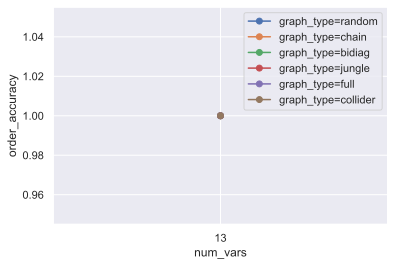

In [52]:
line_plot_over_x(results, exp_args, 
                 x_axis="num_vars",
                 y_axis="order_accuracy",
                 ignore=["edge_prob", "checkpoint_dir", "max_graph_stacking"])

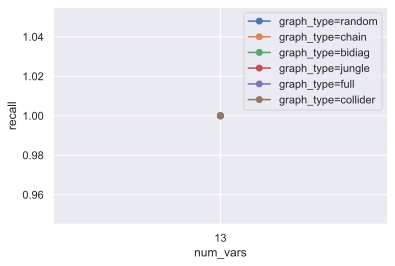

In [53]:
line_plot_over_x(results, exp_args, 
                 x_axis="num_vars",
                 y_axis="recall",
                 ignore=["edge_prob", "checkpoint_dir", "max_graph_stacking"])

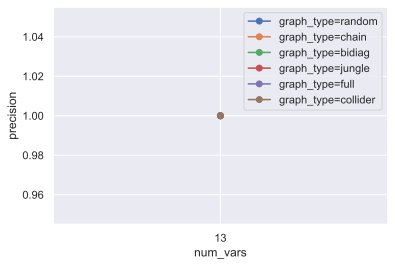

In [54]:
line_plot_over_x(results, exp_args, 
                 x_axis="num_vars",
                 y_axis="precision",
                 ignore=["edge_prob", "checkpoint_dir", "max_graph_stacking"])

## Real-world datasets

In [58]:
def load_real_world(checkpoint_dir):
    folders = sorted(glob(os.path.join(checkpoint_dir, "*")))
    folders = [f for f in folders if os.path.isdir(f)]
    
    results = {}
    exp_args = {}
    for f in folders:
        args_file = os.path.join(f, "args.json")
        assert os.path.isfile(args_file), "Cannot find file %s" % args_file
        with open(args_file, "r") as file_pointer:
            f_args = json.load(file_pointer)
        
        f_name = f.split("/")[-1]
        metric_files = sorted(glob(os.path.join(f, 'metrics_full_log_*.json')))
        datasets = list(set([m.split("/")[-1].split("_")[3] for m in metric_files]))
        for d in datasets:
            fd_name = f_name + "_" + d
            results[fd_name] = []
            exp_args[fd_name] = copy(f_args)
            exp_args[fd_name]["dataset"] = d
            metric_files = sorted(glob(os.path.join(f, 'metrics_full_log_%s_*.json' % d)))
            for m_file in metric_files:
                with open(m_file, "r") as file_pointer:
                    results[fd_name].append(json.load(file_pointer))
                
    return results, exp_args

In [65]:
results, exp_args = load_real_world("checkpoints/array_job_real_7522741/")

In [69]:
exp_args['experiment_1_child']

{'num_seeds': 5,
 'num_epochs': 75,
 'base_seed': 42,
 'cluster': True,
 'lambda_sparse': 0.001,
 'lr_permut': 0.005,
 'lr_gamma': 0.005,
 'checkpoint_dir': 'checkpoints/array_job_real_7522741/experiment_1',
 'order_grads_opt': 'weight_expect_no_denom_weight_intervention',
 'edge_grads_opt': 'weight_expect',
 'beta2_theta': 0.999,
 'N_s': 1,
 'C_s': 200,
 'max_graph_stacking': 200,
 'use_only': '',
 'dataset': 'child'}

In [67]:
group_experiments(exp_args, group_by="lambda_sparse", ignore=["checkpoint_dir"])

([['experiment_1_child', 'experiment_2_child', 'experiment_3_child'],
  ['experiment_1_asia', 'experiment_2_asia', 'experiment_3_asia'],
  ['experiment_1_sachs', 'experiment_2_sachs', 'experiment_3_sachs'],
  ['experiment_1_cancer', 'experiment_2_cancer', 'experiment_3_cancer'],
  ['experiment_1_test', 'experiment_2_test', 'experiment_3_test'],
  ['experiment_1_earthquake',
   'experiment_2_earthquake',
   'experiment_3_earthquake'],
  ['experiment_1_alarm', 'experiment_2_alarm', 'experiment_3_alarm']],
 [{'dataset': 'child'},
  {'dataset': 'asia'},
  {'dataset': 'sachs'},
  {'dataset': 'cancer'},
  {'dataset': 'test'},
  {'dataset': 'earthquake'},
  {'dataset': 'alarm'}])

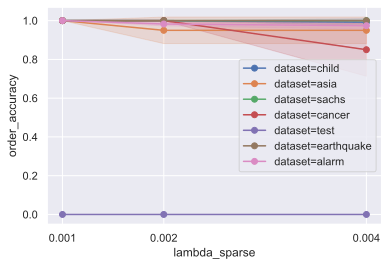

In [68]:
line_plot_over_x(results, exp_args, 
                 x_axis="lambda_sparse",
                 y_axis="order_accuracy",
                 ignore=["checkpoint_dir"])

In [64]:
show_table({k:results[k] for k in results if k.startswith("experiment_1")}, 
           {k:exp_args[k] for k in exp_args if k.startswith("experiment_1")}, 
           y_axis=["order_accuracy", "recall", "precision", "SHD"], ignore=["checkpoint_dir"])

StatisticsError: variance requires at least two data points